In [9]:
# this is a bit of a hack to get relative imports 
# to work as if these notebooks were in a package
# change cwd to project root if 'notebooks' in PATH
from os import chdir
from pathlib import Path
if 'notebooks' in str(Path.cwd()):
    chdir('..')

from typing import Final, Type, Dict, Literal
import datetime as dt

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import numpy as np


import src.constants as const
from src.schemas import DataCatalog
from src.ons_population import ONSPopulationScenario


## Load data catalog

In [10]:
data_catalog = DataCatalog.load_from_yaml()

ons_scenarios = {i.name: ONSPopulationScenario(i) for i in data_catalog.scenario_data_sources[0].scenarios}

In [11]:

dfs= []
for key, value in ons_scenarios.items():
    df = value.interpolated_population(yearly_age_bins=None).groupby('Date').sum(numeric_only=True)
    df = df.rename(columns={'population': key})
    dfs.append(df)
scenarios_df = pd.concat(dfs, axis=1)
scenarios_df.head()

TypeError: GroupBy.sum() got an unexpected keyword argument 'observed'

Text(0.5, 1.0, 'ONS Population Scenarios, 2018-based')

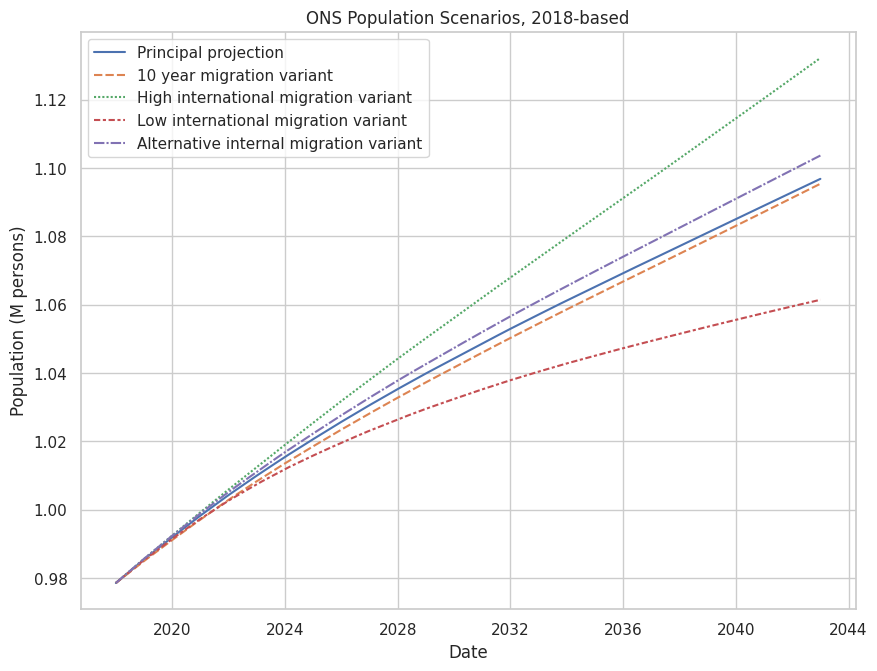

In [42]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, figsize=(10, 7.5))
sns.lineplot(data=scenarios_df/1000000,ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Population (M persons)")
plt.ticklabel_format(style='plain', axis='y')
ax.set_title("ONS Population Scenarios, 2018-based")

## ICB Population change

In [57]:
dfs= []
for key, value in ons_scenarios.items():
    df = value.interpolated_population(yearly_age_bins=None).groupby(['Date','sub_icb']).sum(numeric_only=True)
    df = df.rename(columns={'population': key})
    dfs.append(df)
sub_icb_pop_projections = pd.concat(dfs, axis=1).reset_index()

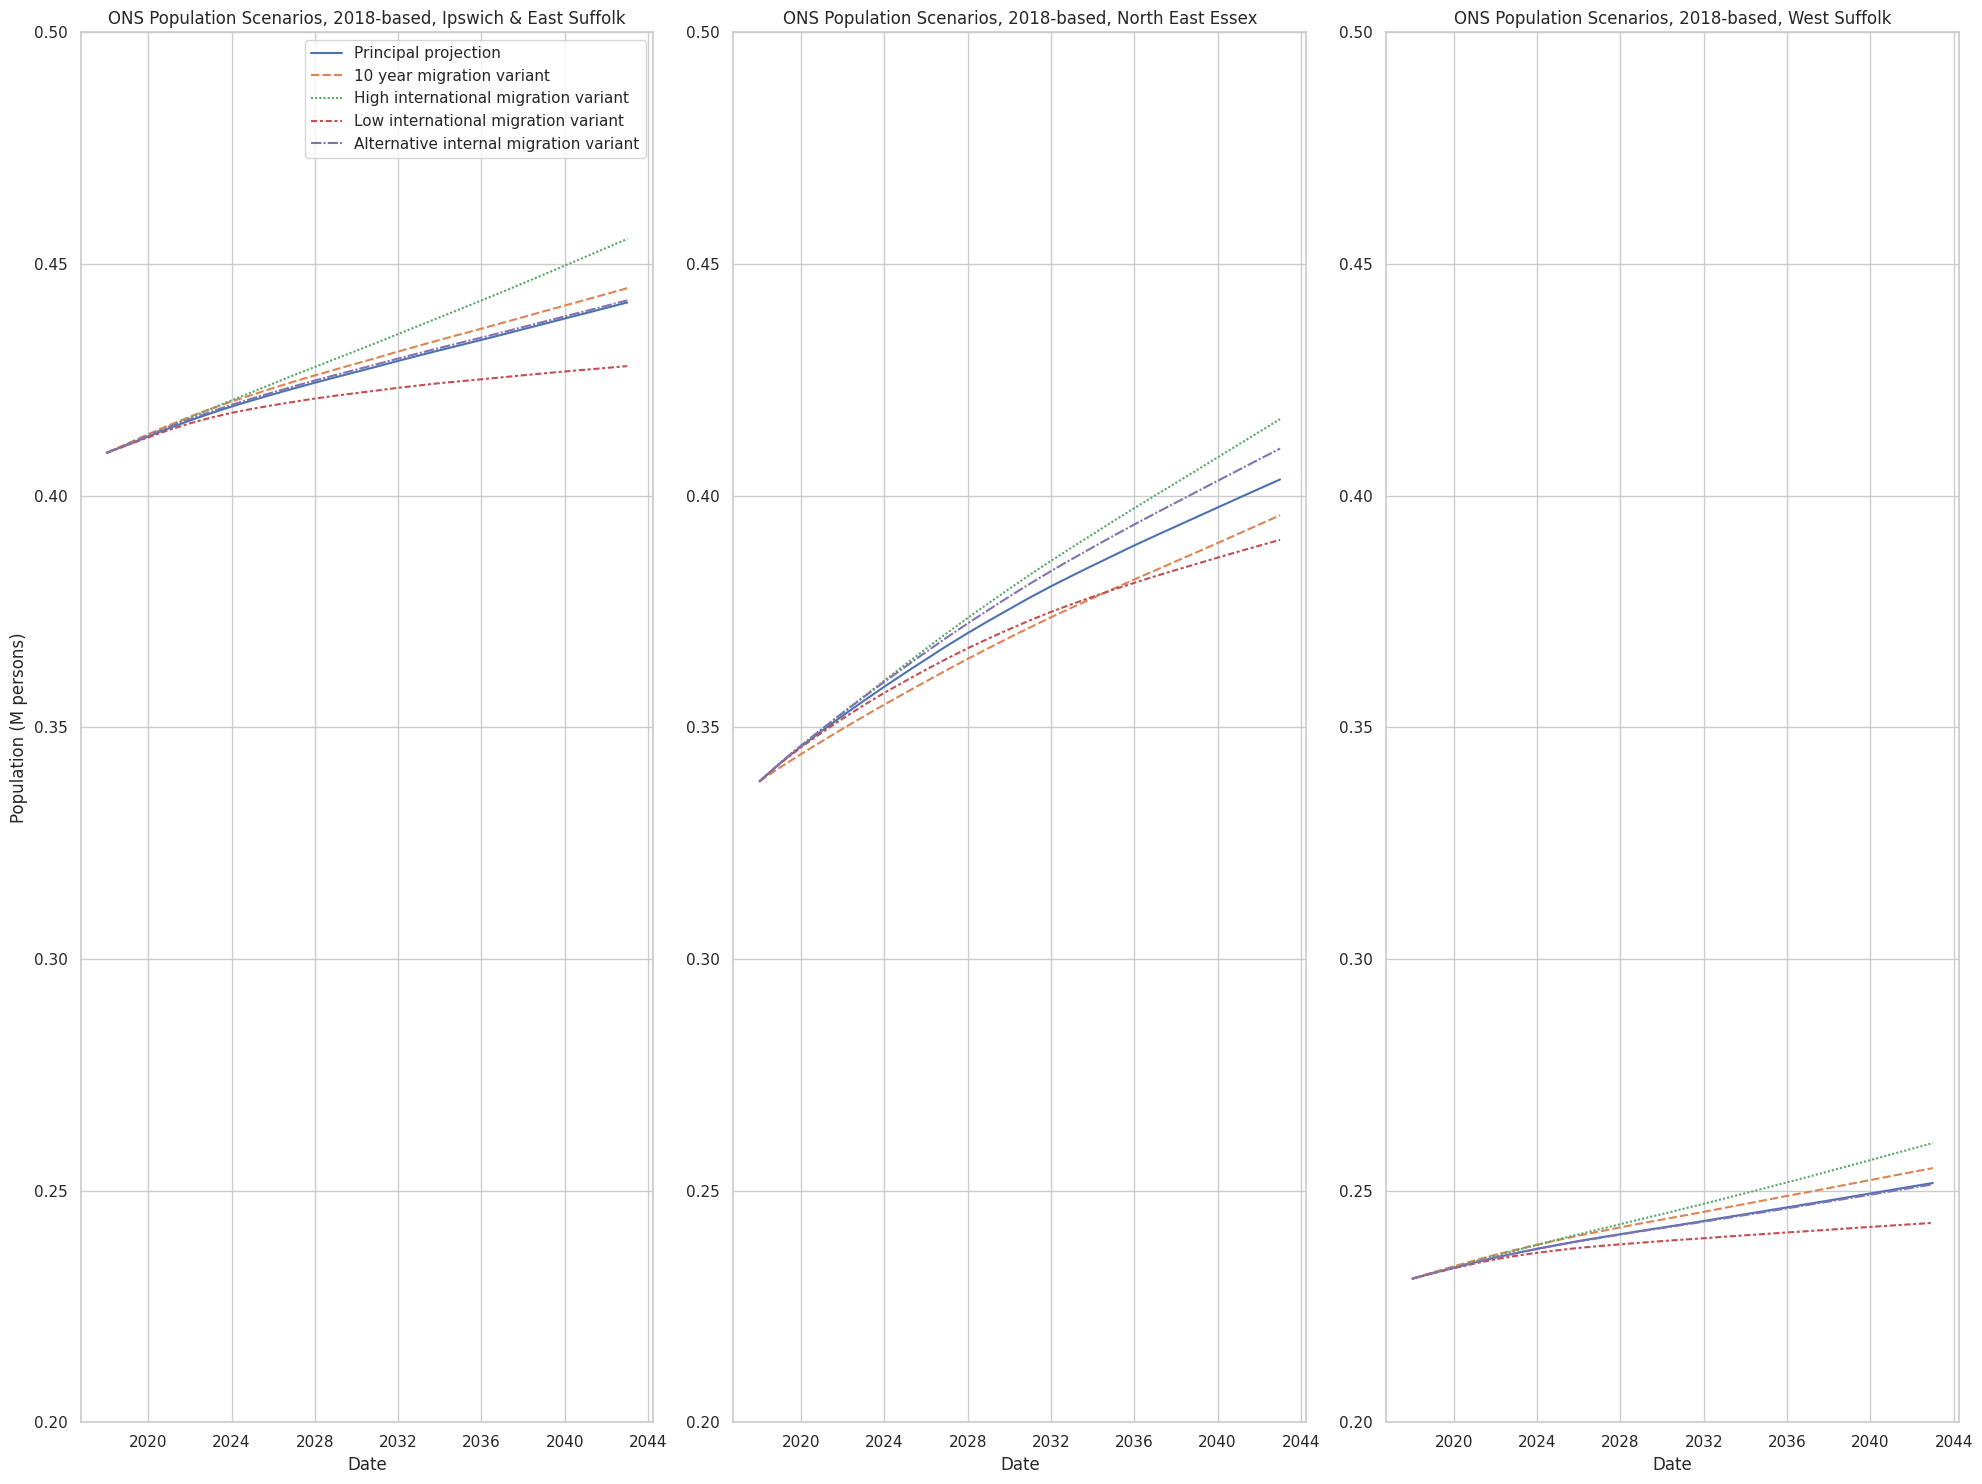

In [69]:
fig, axes = plt.subplots(1,3, figsize= (20,15))
for i, sub_icb in enumerate(sub_icb_pop_projections.sub_icb.unique()):
    sub_icb_pop_mill_df = sub_icb_pop_projections[sub_icb_pop_projections.sub_icb == sub_icb].drop(columns=['sub_icb']).set_index('Date')/1000000
    sns.lineplot(data=sub_icb_pop_projections[sub_icb_pop_projections.sub_icb == sub_icb].drop(columns=['sub_icb']).set_index('Date')/1000000,ax=axes[i])
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Population (M persons)")
    plt.ticklabel_format(style='plain', axis='y')
    axes[i].set_title(f"ONS Population Scenarios, 2018-based, {sub_icb}")
    axes[i].set_ylim(0.20, 0.5)
    if i == 0:
        pass
    else:
        axes[i].legend().remove()
        axes[i].yaxis.label.set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
for sub_icb in const.ICB_SUB_GROUPS:
    df = pd.read_csv(f"../data/processed/ONS/ONS_{sub_icb}_population.csv", index_col=0, parse_dates=True)
    df = df.groupby('Date').sum(numeric_only=True)
    sns.lineplot(data=df/1000000,ax=ax, label=sub_icb)

In [48]:
scenarios_change_df= scenarios_df
scenarios_change_df = scenarios_change_df.loc[(scenarios_change_df.index.year.isin((2023,2033,2043))) & (scenarios_change_df.index.month==1) & (scenarios_change_df.index.day==1)]
pop_percent_increases = round((scenarios_change_df - scenarios_change_df.iloc[0]) / scenarios_change_df.iloc[0],3).iloc[1:]
pop_percent_increases.to_csv("outputs/analysis/population_percent_increases.csv")
annotated_pop_tbl = round((scenarios_change_df.iloc[1:] - scenarios_change_df.iloc[0]),3).astype(str) + " (" + (pop_percent_increases*100).round(1).astype(str) + "%)"
annotated_pop_tbl.to_csv("outputs/analysis/population_absolute_increases.csv")

,Principal projection,10 year migration variant,High international migration variant,Low international migration variant,Alternative internal migration variant
Date,,,,,
2033-01-01,47135 (4.7%),46133 (4.6%),61343 (6.1%),32920 (3.3%),49941 (4.9%)
2043-01-01,86840 (8.6%),87049 (8.6%),119720 (11.8%),53946 (5.4%),92528 (9.2%)


In [41]:
absolute_increases

,Principal projection,10 year migration variant,High international migration variant,Low international migration variant,Alternative internal migration variant
Date,,,,,
2033-01-01,47135,46133,61343,32920,49941
2043-01-01,86840,87049,119720,53946,92528


absolute_increases

##  What is the population growth for each scenario in each area?

1. Total

In [16]:
ons_scenarios['10 year migration variant'].interpolated_population(yearly_age_bins=None)

,Date,population,sub_icb,AGE_GROUP
0,2018-01-01,4032,Ipswich & East Suffolk,0
1,2018-01-02,4032,Ipswich & East Suffolk,0
2,2018-01-03,4031,Ipswich & East Suffolk,0
3,2018-01-04,4031,Ipswich & East Suffolk,0
4,2018-01-05,4031,Ipswich & East Suffolk,0
...,...,...,...,...
9127,2042-12-28,6823,West Suffolk,90 and over
9128,2042-12-29,6823,West Suffolk,90 and over
9129,2042-12-30,6824,West Suffolk,90 and over
9130,2042-12-31,6824,West Suffolk,90 and over


In [8]:
referrals_source_names = [i.name for i in data_catalog.single_data_sources if "Referrals" in i.name]

In [13]:
referrals_dfs = {i.name:i.load() for i in data_catalog.single_data_sources if "Referrals" in i.name}

In [17]:
ref_df= list(referrals_dfs.values())[0]

In [33]:
snee_df = ref_df.loc[ref_df['Commissioner Parent Org Name'] == 'NHS SUFFOLK AND NORTH EAST ESSEX INTEGRATED CARE BOARD'].copy()
snee_df.loc[:,'referral_in_icb'] = snee_df['Commissioner Parent Org Name'] == snee_df['Provider Parent name']

In [42]:
snee_df.columns

Index(['Periodname', 'Provider Parent org code', 'Provider Parent name',
       'Provider Org code', 'Provider Org name',
       'Commissioner Parent Org Code', 'Commissioner Parent Org Name',
       'Commissioner Org Code', 'Commissioner Org Name', 'Op Gprefsmade M',
       'Op Otherrefsmade M', 'Op Gprefsmade Ga M', 'Op Otherrefsmade Ga M',
       'referral_in_icb'],
      dtype='object')

In [46]:
snee_df.groupby(['Periodname','referral_in_icb'])[['Op Gprefsmade M',
       'Op Otherrefsmade M', 'Op Gprefsmade Ga M', 'Op Otherrefsmade Ga M']].sum()

Op Gprefsmade M  Op Otherrefsmade M  \
Periodname      referral_in_icb                                        
MRR-April-2023  False                       1618                2748   
                True                       11469                8880   
MRR-August-2023 False                       1624                3151   
                True                       12627               10580   
MRR-July-2023   False                       1839                3177   
                True                       13669               10671   
MRR-June-2023   False                       1690                3217   
                True                       14168               10779   
MRR-May-2023    False                       1713                3110   
                True                       13201               10922   

                                 Op Gprefsmade Ga M  Op Otherrefsmade Ga M  
Periodname      referral_in_icb                                             
MRR-April-2023  False                          1598                   2572  
                True                          11368                   8644  
MRR-August-2023 False                          1605                   2988  
                True                          12574                  10262  
MRR-July-2023   False                          1808                   2980  
                True                          13546                  10388  
MRR-June-2023   False                          1659                   3028  
                True                          14073                  10483  
MRR-May-2023    False                          1692                   2927  
                True                          13104                  10571

### Total population

<Axes: >

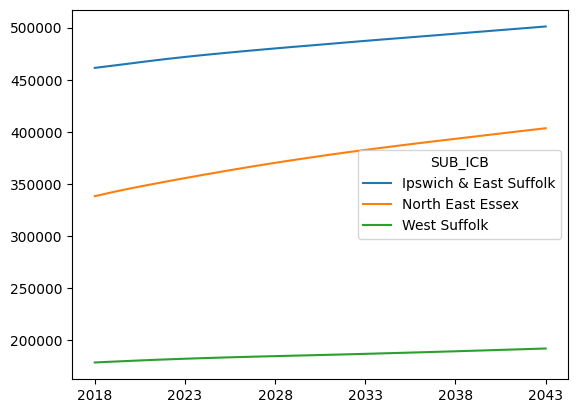

In [ ]:
ons_total_df = ons_df.loc[ons_df['AGE_GROUP']=='All ages']
ons_total_df.groupby('SUB_ICB').sum(numeric_only=True).T.plot()

In [ ]:
def calc_oadr_status(ons_age_group:str):
    ons_age_group = ons_age_group.replace(" and over", "")
    try:
        ons_age = int(ons_age_group)
    except ValueError:
        return None
    if ons_age < 65 and ons_age >=20:
        return 'Working'
    elif ons_age >=65:
        return 'Retired'
    else:
        return None



In [ ]:
ons_df['WorkingAge'] = ons_df['AGE_GROUP'].map(calc_oadr_status)

<Axes: >

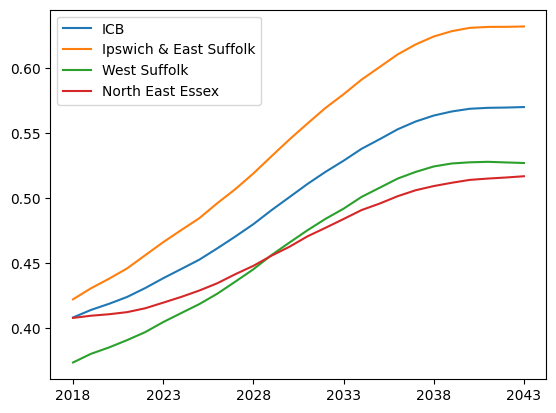

In [ ]:
oadr_df = ons_df.groupby(['WorkingAge']).sum(numeric_only=True).T
oadr_df['ICB'] = oadr_df['Retired']/  oadr_df['Working']
sub_icb_oadrs = [oadr_df['ICB']]
for sub_icb in const.SUB_ICB_CODES.values():
    sub_icb_df = ons_df.loc[ons_df['SUB_ICB']==sub_icb].copy()
    sub_icb_df = sub_icb_df.groupby(['WorkingAge']).sum(numeric_only=True).T
    sub_icb_oadr = sub_icb_df['Retired']/  sub_icb_df['Working']
    sub_icb_oadr.name = sub_icb
    sub_icb_oadrs.append(sub_icb_oadr)
oadr_df = pd.concat(sub_icb_oadrs, axis=1)
oadr_df.plot()




In [ ]:
sub_icb_df

WorkingAge,Retired,Working
2018,76238.000,186829.000
2019,77356.630,188790.905
2020,78306.862,190585.112
2021,79268.343,192163.862
2022,80323.446,193341.481
2023,81579.698,194338.562
2024,82891.447,195408.651
2025,84254.733,196359.172
2026,85760.852,197284.009
2027,87461.297,198027.157


In [ ]:
print(sorted(ons_df['AREA_NAME'].unique()))

['Babergh', 'Colchester', 'Forest Heath', 'Ipswich', 'Mid Suffolk', 'St Edmundsbury', 'Suffolk Coastal', 'Tendring']


In [ ]:
snee_df= snee_df.set_index(['APPOINTMENT_MONTH','Sub ICB Area'])

In [ ]:
import calendar
import numpy as np
import datetime as dt

def get_numdays(df_:pd.DataFrame):
    month_values = df_.index.get_level_values('APPOINTMENT_MONTH')
    years, months =  month_values.year, month_values.month

    def _num_days_in_month(year:int, month:int):
        # to be used by np.vectorize
        return calendar.monthrange(year, month)[1]

    num_days_in_month_v_ = np.vectorize(_num_days_in_month)

    return num_days_in_month_v_(years,months)

def get_workingdays(a_:np.array):
    years, months =  a_.year, a_.month

    #
    def _num_workingdays_in_month(year,month):
        workingdays = 0
        day = 1
        while day <= calendar.monthrange(year,month)[1]:
            the_date =  dt.datetime(year,month,day)
            if the_date.isoweekday() and the_date not in ENGLAND_BANK_HOLIDAYS:
                workingdays +=1
            day += 1
        return workingdays

    vec_workingdays = np.vectorize(_num_workingdays_in_month)
    return vec_workingdays(years, months)

snee_df['num_days_in_month'] = get_numdays(snee_df)
snee_df['num_workingdays_in_month'] = get_workingdays(snee_df.index.get_level_values('APPOINTMENT_MONTH'))


total_appts = (snee_df
               .groupby(['Sub ICB Area','APPOINTMENT_MONTH'])
               .sum(numeric_only=True)
               .reset_index()
               .pivot(columns='Sub ICB Area', index='APPOINTMENT_MONTH',values='COUNT_OF_APPOINTMENTS')
               )

KeyError: ignored

In [ ]:
snee_df['Appointments/day'] = snee_df['COUNT_OF_APPOINTMENTS'] / snee_df['num_days_in_month']
snee_df['Appointments/working day'] = snee_df['COUNT_OF_APPOINTMENTS'] / snee_df['num_days_in_month']

In [ ]:
snee_appt_df = snee_df.reset_index().pivot_table(values=['Appointments/day'], index='APPOINTMENT_MONTH', columns='Sub ICB Area', aggfunc='sum')

In [ ]:
snee_appt_df.plot()

In [ ]:
fig, axes = plt.subplots(nrows=3,ncols=1, figsize=(15,20))
for plot_i, sub_icb in enumerate(snee_df.index.get_level_values('Sub ICB Area').unique()):
    # slice by icb
    sub_icb_df = snee_df.loc[snee_df.index.get_level_values('Sub ICB Area') == sub_icb].copy().reset_index()
    appts_workingday = sub_icb_df.groupby('APPOINTMENT_MONTH')['Appointments/working day'].sum()
    axes[plot_i].scatter(x=appts_workingday.index,y=appts_workingday.values, label='mean appointments/working day', marker='.', alpha=0.4, color='red')
    # appts_day = sub_icb_df.groupby('APPOINTMENT_MONTH')['Appointments/day'].sum()
    # axes[plot_i].scatter(x=appts_day.index, y=appts_day.values, label="mean appointments/day")
    appts_total= sub_icb_df.groupby('APPOINTMENT_MONTH')['COUNT_OF_APPOINTMENTS'].sum()
    second_ax = axes[plot_i].twinx()
    second_ax.plot(appts_total,label='Total appointments')
    if plot_i == 2:
        axes[plot_i].legend(ncols=3)
    axes[plot_i].set_title(sub_icb)
plt.tight_layout()
plt.show()






In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10))
total_appts.plot.area(ax=ax)
ax.set_title('Total Appointments in SNEE ICB')

In [ ]:
from enum import Enum
from dataclasses import dataclass



snee_df['num_days_in_month'] = get_numdays(snee_df)
snee_df['num_workingdays_in_month'] = get_workingdays(snee_df.index.get_level_values('APPOINTMENT_MONTH'))


total_appts = (snee_df
               .groupby(['Sub ICB Area','APPOINTMENT_MONTH'])
               .sum(numeric_only=True)
               .reset_index()
               .pivot(columns='Sub ICB Area', index='APPOINTMENT_MONTH',values='COUNT_OF_APPOINTMENTS')
               )











In [ ]:
distribution of time taken, for each staff type, for each appointment type, for each ICB
needs

STAFF_PROBABILITY = {"GP":float(1/3), "Nurse":float(3/6), "AHP": float(1/6) }


In [ ]:
import random

In [ ]:
random.choices(list(staffs.keys()), weights=list(staffs.values()))

In [ ]:
snee_df.groupby(['HCP_TYPE','APPT_MODE'])['COUNT_OF_APPOINTMENTS'].count()

In [ ]:
from ast import literal_eval

In [ ]:
eval("float(1/4)")